# Researching a Pairs Trading Strategy

"Pairs trading is a relative-value arbitrage strategy that has been known in the quantitative finance community since the mid-1980s. It seeks to identify two securities whose prices tend to stay together. Upon divergence, the undervalued security is bought long and the overvalued one is sold short, which is typically referred to as a contrarian philosophy (buy when everyone else is selling and vice versa). When the prices revert back to their historical equilibrium, the trade is closed and a profit is realized."

https://bookdown.org/palomar/portfoliooptimizationbook/15-pairs-trading.html

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
np.random.seed(107)

import matplotlib.pyplot as plt

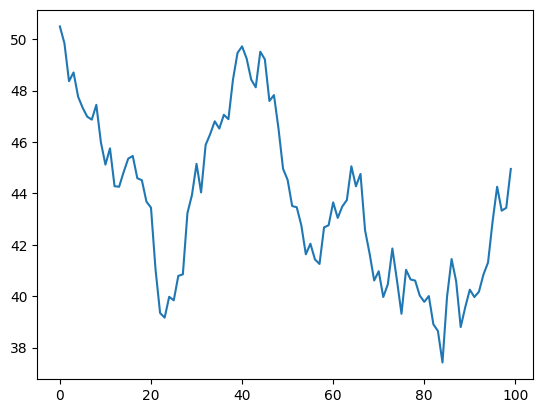

In [2]:
#We model X's daily returns by drawing from a normal distribution.
#Then, we perform a cumulative SUM to get the value of X on each day.

X_returns = np.random.normal(0, 1, 100) #Generate the daily returns

#SUM them and shift all the prices up into a reasonable range

X = pd.Series(np.cumsum(X_returns), name = 'X') + 50
X.plot();

We now generate Y, which should have a strong economic connection to X, resulting in similar price variations. We achieve this by shifting X upward and adding random noise from a normal distribution.

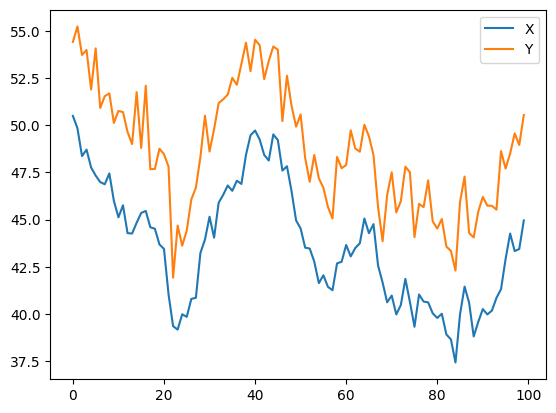

In [3]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis = 1).plot();

# Def: Cointegration

"Cointegration is a statistical concept that refers to the phenomenon where nonstationary processes can have linear combinations that are stationary."

$$ y_{1t} = \gamma x_{t} + w_{1t} $$
$$ y_{2t} = x_{t} + w_{2t} $$

We have created an example of two cointegrated series. Cointegration is a distinct form of correlation, where a linear combination of two time series fluctuates around a mean. This combination is consistently linked to the same probability distribution over time.

https://www.sciencedirect.com/topics/social-sciences/cointegration#:~:text=Cointegration%20is%20a%20statistical%20concept,linear%20combinations%20that%20are%20stationary.

https://bookdown.org/palomar/portfoliooptimizationbook/15.2-cointegration-vs-correlation.html

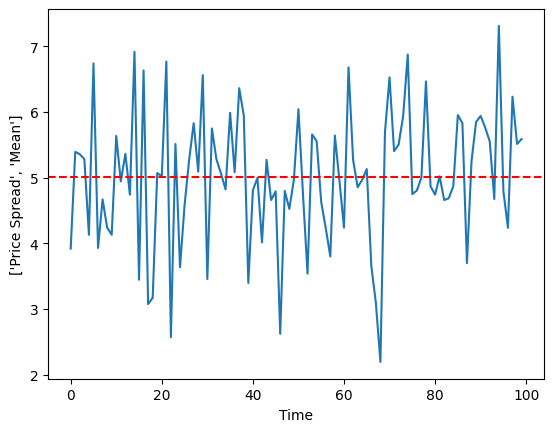

In [4]:
(Y - X).plot()
plt.axhline((Y - X).mean(), color = 'red', linestyle = '--')
plt.xlabel('Time')
plt.ylabel(['Price Spread', 'Mean']);

# Testing for Cointegration

There is a convenient test that lives in statsmodels.tsa.stattools. We should see a very low p-value, as we've artifically created two series that are as cointegrated as physically possible.

In [5]:
#Compute the p-value of the cointegration test; this will inform us whether
#the spread between the 2 time series is stationary around its mean.

score, pvalue, _ = coint(X, Y)

if pvalue < 0.05:
    print('Likely Cointegrated.')
else:
    print('Likely Not Cointegrated.')

print(f'p-value: {pvalue}')

Likely Cointegrated.
p-value: 2.0503418653415035e-16


# Def: Correlation

"Correlation is a basic concept in probability that refers to how “related” two random variables are. We can use this measure for stationary time series but definitely not with nonstationary time series. In fact, when we refer to correlation between two financial assets, we are actually employing this concept on the returns of the assets and not the price values."

$$\rho = \frac{E[(Δy_{1t}-\mu_{1})⋅(Δy_{2t}-\mu_{2})]}{\sqrt{Var(Δy_{1t})⋅Var(Δy_{2t})}}$$

https://bookdown.org/palomar/portfoliooptimizationbook/15.2-cointegration-vs-correlation.html

In [6]:
X.corr(Y)

0.9497090646385932

# Correlation vs. Cointegration

Cointegration describes the long-term relationship between asset prices, while correlation describes the short-term relationship between returns.

https://bookdown.org/palomar/portfoliooptimizationbook/15.2-cointegration-vs-correlation.html

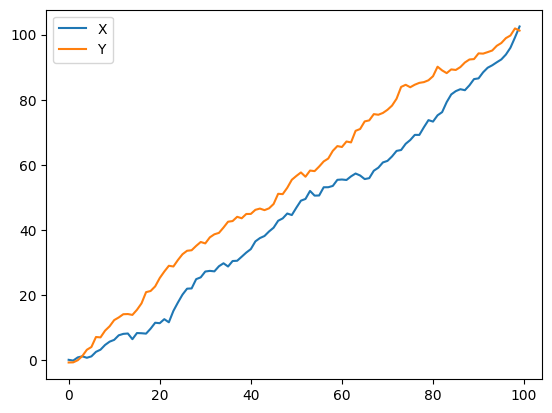

In [7]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(1, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name = 'X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name = 'Y')

pd.concat([X_diverging, Y_diverging], axis = 1).plot();

In [8]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging, Y_diverging)
print('Cointegration Test p-value: ' + str(pvalue))

Correlation: 0.9883877288043449
Cointegration Test p-value: 0.9022713342921642


# Cointegration Without Correlation

A simple example of this case is a normally distributed series and a square wave.

In [9]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name = 'Y2') + 20
Y3 = Y2.copy()

In [10]:
#Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

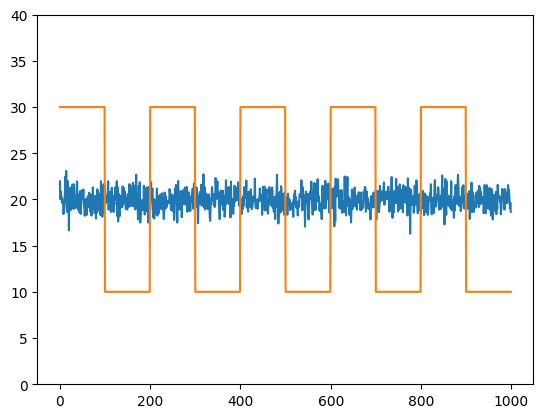

In [11]:
Y2.plot()
Y3.plot()
plt.ylim([0,40]);

In [12]:
# Correlation is nearly zero
print('Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2, Y3)
print('Cointegration Test p-value: ' + str(pvalue))

Correlation: -0.04130406958091664
Cointegration Test p-value: 0.0


# Def: Hedge Position

"A hedge is an investment that is selected to reduce the potential for loss in other investments because its price tends to move in the opposite direction. This strategy works as a kind of insurance policy, offsetting any steep losses in other investments."

https://www.investopedia.com/terms/h/hedge.asp

In [14]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [15]:
pip install yfinance

In [16]:
import yfinance as yf

# Set the start and end date
start_date = '2015-01-01'
end_date = '2025-01-23'

# Define the ticker list
tickers_list = ['INTC', 'AMD', 'QCOM', 'NVDA']

# Create placeholder for data
data = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    data[ticker] = yf.download(ticker,
                               start_date,
                               end_date)['Close']

# Print first 5 rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,INTC,AMD,QCOM,NVDA
Date,,,,
2015-01-02,27.896458,2.67,55.551231,0.483144
2015-01-05,27.581890,2.66,55.289505,0.474983
2015-01-06,27.067850,2.63,54.504215,0.460582
2015-01-07,27.635603,2.58,55.139923,0.459382
2015-01-08,28.149643,2.61,55.723255,0.476663


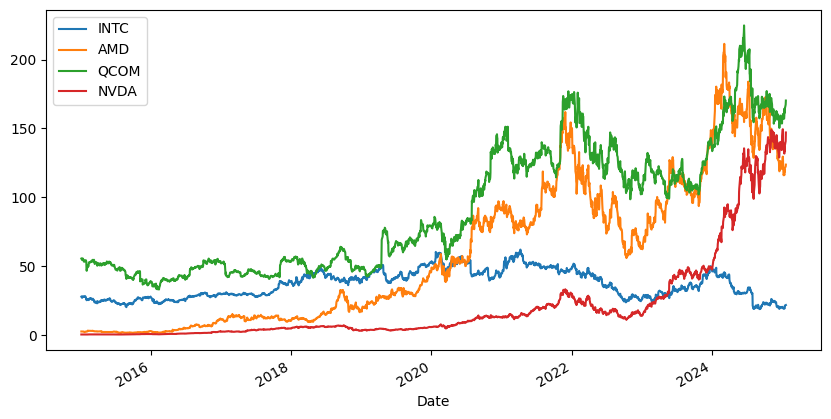

In [17]:
data.plot(figsize=(10, 5))
plt.show()

In [18]:
data['INTC'].head()

,INTC
Date,
2015-01-02,27.896458
2015-01-05,27.581890
2015-01-06,27.067850
2015-01-07,27.635603
2015-01-08,28.149643


Cointegrated pairs [('AMD', 'QCOM')]


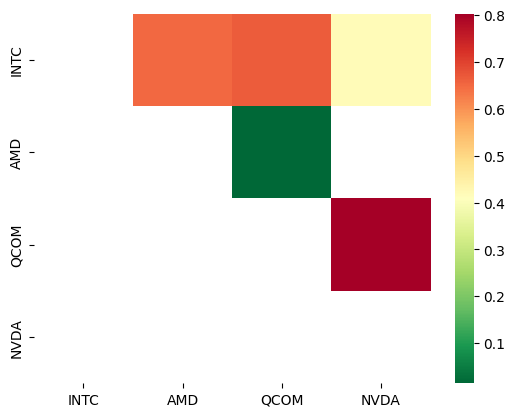

In [19]:
#We will run our method on the list and see if any pairs are cointegrated.
#Heatmap to show the p-values of cointegration test between each pair of stock.

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn as sns
sns.heatmap(pvalues, xticklabels=tickers_list, yticklabels=tickers_list, cmap='RdYlGn_r'
            , mask = (pvalues >= 0.95))
print('Cointegrated pairs', pairs)

In [20]:
S1 = data['AMD']
S2 = data['QCOM']

In [21]:
score, pvalue, _ = coint(S1, S2)
print('Cointegration Stocks p-value: ' + str(pvalue))

Cointegration Stocks p-value: 0.014745851287211629


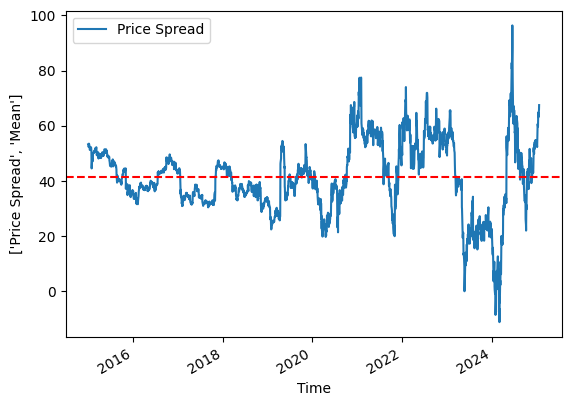

In [31]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AMD']
b = results.params['AMD']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color = 'red', linestyle = '--')
plt.xlabel('Time')
plt.ylabel(['Price Spread', 'Mean']);
plt.legend(['Price Spread']);

In [33]:
np.mean(S2)

90.16851255779636

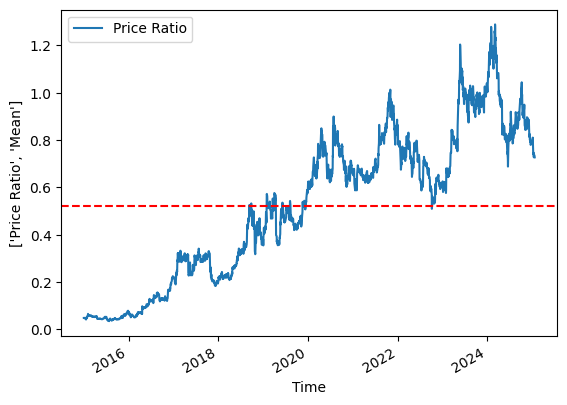

In [32]:
ratio = S1 / S2
ratio.plot()
plt.axhline(ratio.mean(), color = 'red', linestyle = '--')
plt.xlabel('Time')
plt.ylabel(['Price Ratio', 'Mean']);
plt.legend(['Price Ratio']);

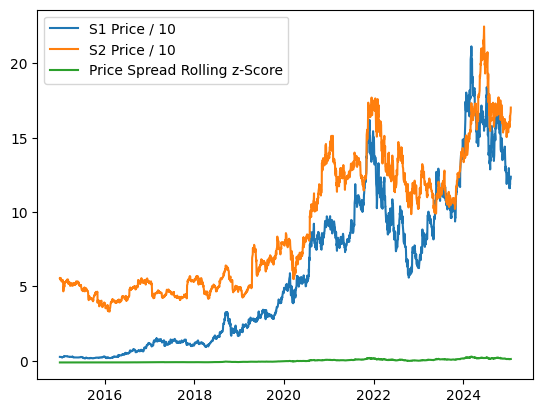

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore(S1).index, zscore(S1).values/10)

plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

In [34]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

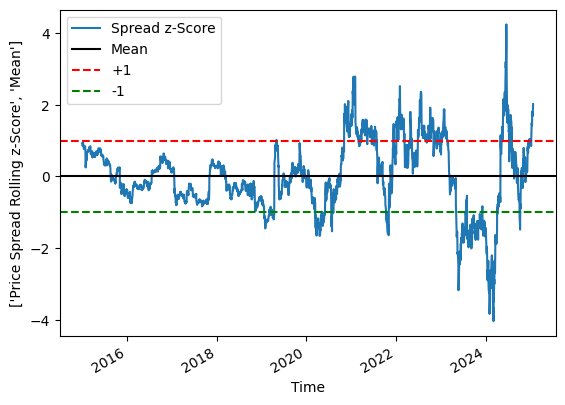

In [35]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color = 'black')
plt.axhline(1.0, color = 'red', linestyle = '--')
plt.axhline(-1.0, color = 'green', linestyle = '--')
plt.xlabel('Time')
plt.ylabel(['Price Spread Rolling z-Score', 'Mean']);
plt.legend(['Spread z-Score','Mean','+1','-1']);

# Simple Trading Strategy
*   Go "Long" the spread whenever the z-score is below -1.0
*   Go "Short" the spread when the z-score is above 1.0
*   Exit positions when the z-score approaches to zero.





In [40]:
pip install pandas statsmodels matplotlib

<ipython-input-41-2536359e0fc9>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1])  # Get the beta coefficient for S2
<ipython-input-41-2536359e0fc9>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1])  # Get the beta coefficient for S2
<ipython-input-41-2536359e0fc9>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas.append(model.params[1])  # Get the beta coefficient fo

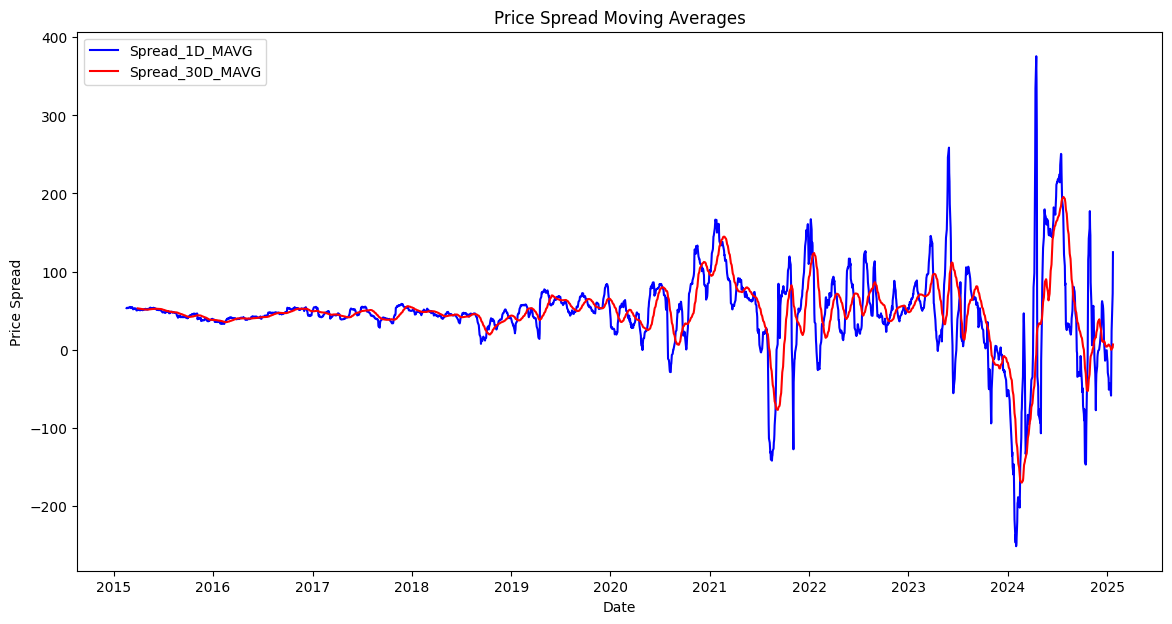

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create a function to calculate rolling beta
def rolling_beta(S1, S2, window):
    betas = []
    for i in range(window, len(S1)):
        y = S1[i-window:i]  # Dependent variable
        X = S2[i-window:i]  # Independent variable
        X = sm.add_constant(X)  # Add a constant for the intercept
        model = sm.OLS(y, X).fit()
        betas.append(model.params[1])  # Get the beta coefficient for S2
    return pd.Series(betas, index=S1.index[window:])

# Calculate rolling beta coefficient
window_size = 30
rolling_beta_vals = rolling_beta(S1, S2, window=window_size)

# Calculate the spread
spread = S2[window_size:] - rolling_beta_vals * S1[window_size:]
spread.name = 'spread'

# Get the 1-day moving average of the price spread
spread_1d_avg = spread.rolling(window=1).mean()
spread_1d_avg.name = 'spread_1d_avg'

# Get the 30-day moving average
spread_30d_avg = spread.rolling(window=30).mean()
spread_30d_avg.name = 'spread_30d_avg'

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(spread_1d_avg.index, spread_1d_avg.values, label='Spread_1D_MAVG', color='blue')
plt.plot(spread_30d_avg.index, spread_30d_avg.values, label='Spread_30D_MAVG', color='red')

plt.title('Price Spread Moving Averages')
plt.legend()
plt.ylabel('Price Spread')
plt.xlabel('Date')
plt.show()

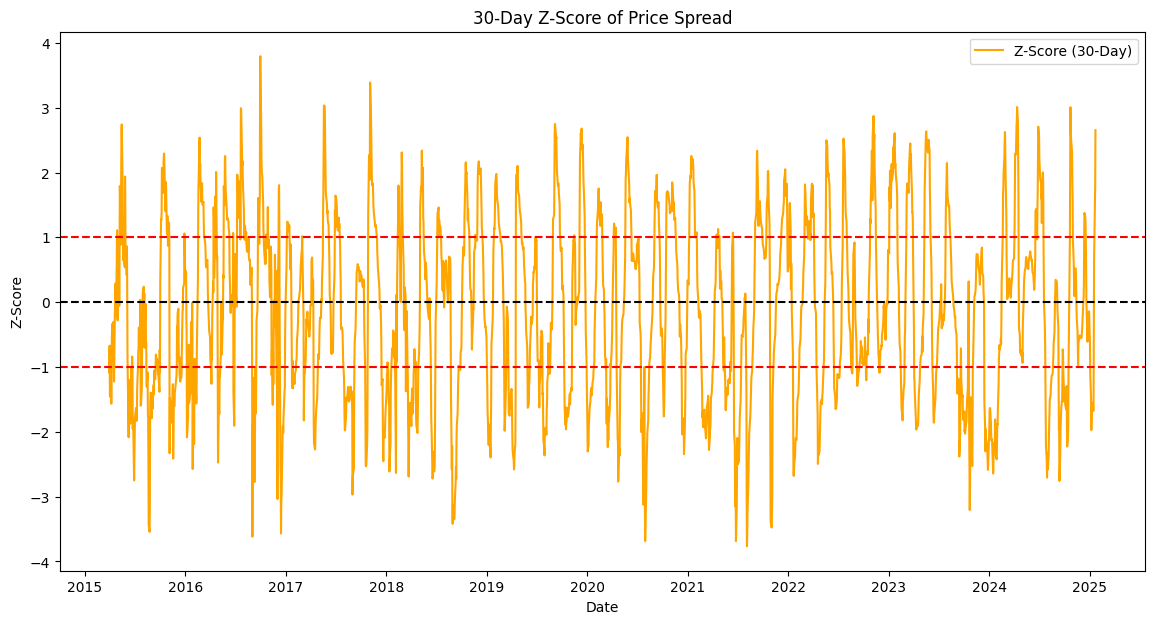

In [46]:
# Create a rolling 30-day standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std_30'

# Compute the z-score for each day
mean_spread = spread.rolling(window=30).mean()
zscore_30 = (spread - mean_spread) / std_30
zscore_30.name = 'zscore_30'

# Plotting the results if needed
plt.figure(figsize=(14, 7))
plt.plot(zscore_30.index, zscore_30.values, label='Z-Score (30-Day)', color='orange')
plt.title('30-Day Z-Score of Price Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')
plt.legend()
plt.show()

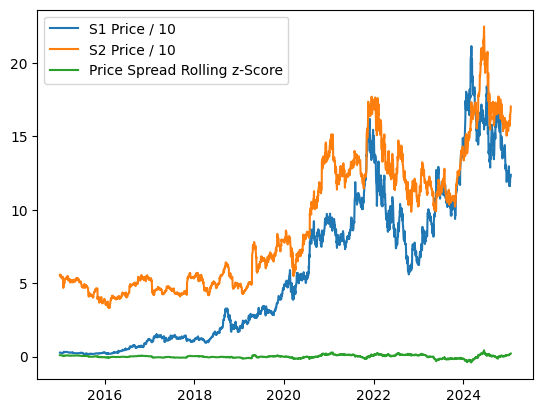

In [36]:
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore(spread).index, zscore(spread).values/10)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);